In [5]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import math
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli,\
    basis_T_to_pauli, reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_qaoa_X, get_optimizer

import seaborn as sns
from copulas.multivariate import GaussianMultivariate
import joblib

import time
cudaq.set_target("nvidia")
np.random.seed(50)
state = np.random.get_state()
modes = ["X", "Preserving"]

LOOP = 100
oversample_factor = 2.1
min_P, max_P = 100, 300
hamiltonian_boost = 100

TARGET_QUBIT = 4
N_ASSETS = 3
LAMB = 1.5 # Budget Penalty
Q = 0 # Volatility Weight

(323, 2)


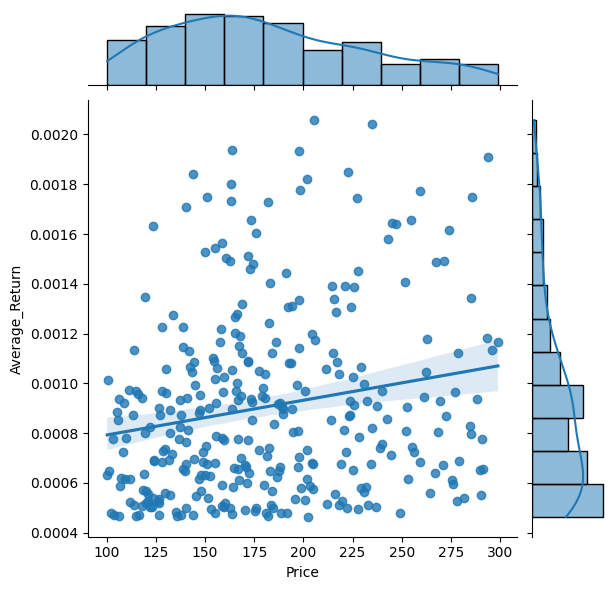

In [6]:

np.random.set_state(state)
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
# samples = GM_loaded.sample(50)
samples = GM_loaded.sample(int(N_ASSETS * LOOP * oversample_factor))
samples = samples[(samples["Price"] > min_P) & (samples["Price"] < max_P)]
# print(samples["Average_Return"].min(), samples["Average_Return"].max())
# print(samples["Price"].min(), samples["Price"].max())
print(samples.shape)
assert samples.shape[0] > N_ASSETS * LOOP, "Please increase the oversample factor to get more samples ;-;"
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
samples = samples.to_numpy()
plt.show()

In [3]:
def find_budget(target_qubit, P):
    n_assets = len(P)
    mi, ma = 0, max_P * ((1 << math.ceil(target_qubit/n_assets))-1)
    cou = 0
    mid = (mi + ma)/2
    while (N := np.sum(np.int32(np.floor(np.log2(mid/P))) + 1)) != target_qubit:
        if N < target_qubit:
            mi = mid
        else:
            ma = mid
        # print()
        mid = (mi + ma)/2
        cou += 1
        if cou > 100:
            assert False, "Cannot find budget for target qubit (Should not happen, Please tell trusted adult lol)"
    return mid

# a = np.array([186, 195, 131])
# b = find_budget(22, a)
# print(b)
# print(np.int32(np.floor(np.log2(b/a))) + 1)

In [4]:
for i in range(LOOP):
    P = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 0]
    ret = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 1]
    cov = np.random.rand(N_ASSETS, N_ASSETS)
    cov += cov.T
    q = 0 # Volatility Weight
    B = find_budget(TARGET_QUBIT, P)
    P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)

    for mode in modes:
        lamb = LAMB if mode == "X" else 0 # Budget Penalty

        QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
        H = qubo_to_ising(QU, lamb).canonicalize() * hamiltonian_boost
        idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use = process_ansatz_values(H)